In [1]:
%pylab inline
from collections import OrderedDict
import pickle
import numpy as np
import seaborn as sns
from tqdm import trange
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from scipy.spatial.distance import pdist,squareform
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

import warnings
warnings.filterwarnings('ignore') 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Data Loading Helper Functions

In [2]:
def rename_groups(df):
    
    """
    Function that takes a dataframe as input
    Returns the same dataframe but with a new category column
    Category column contains updated group labels accounting for different controls
    """
    
    new_cat = []
    
    for row in df.index:
        """
        if df['group'][row].split('_')[0] == 'NGH':
            NGHtype = uuid_NameMap[df['uuid'][row]]
            if NGHtype.split('_')[-1].startswith('05'):
                new_cat.append('Ctrl-LNB')
            elif NGHtype.split('_')[-1].startswith('03'):
                new_cat.append('Ctrl-EE/SI')
        else:
        """
        new_cat.append(df['group'][row].split('_')[0])

    df['category'] = new_cat
    
    return df

In [3]:
def reformat_df(subset_df, metric_interest):
    """
    Take multi-index summary dataframe from Moseq fingerprint code as well as a metric of interest
    Reformat into single index dataframe for further analysis
    Returns dataframe with category label, position, uuid, and avg_time for that uuid in that metric
    """

    category = []
    position = []
    uuid_num = []
    avg_time = []
    
    for ix in subset_df[metric_interest]:
        for cat, uuid in subset_df[metric_interest][ix].index:
            category.append(cat)
            position.append(ix)
            uuid_num.append(uuid)
            avg_time.append(subset_df[metric_interest][ix][cat][uuid])
    
    
    return rename_groups(pd.DataFrame(data={'group': category, 'Metric': position, 'uuid': uuid_num, 'avg_time': avg_time}))


# Load Data

In [4]:
summary_df = pd.read_csv('../../data/fingerprints/full/fingerprint_summary_full.csv', index_col=[0, 1], header=[0, 1])
range_dict = pd.read_csv('../../data/fingerprints/full/fingerprint_summary_full.csv')

In [5]:
females_df = summary_df[summary_df.index.get_level_values('group').str.contains('Male')]

In [6]:
m_pos_df = reformat_df(females_df, 'dist_to_center_px')
m_height_df = reformat_df(females_df, 'height_ave_mm')
m_length_df = reformat_df(females_df, 'length_mm')
m_vel_df = reformat_df(females_df, 'velocity_2d_mm')
m_moseq_df = reformat_df(females_df, 'MoSeq')

m_pos_list = []
m_height_list = []
m_length__list = []
m_vel_list = []
m_moseq_list = []
uuids = []
labels = []

for ix, uuid in enumerate(list(set(m_pos_df['uuid']))):
    labels.append(m_pos_df[m_pos_df['uuid'] == uuid].iloc[1]['category'])
    m_pos_list.append(m_pos_df[m_pos_df['uuid'] == uuid]['avg_time'].values)
    m_height_list.append(m_height_df[m_height_df['uuid'] == uuid]['avg_time'].values)
    m_length__list.append(m_length_df[m_length_df['uuid'] == uuid]['avg_time'].values)
    m_vel_list.append(m_vel_df[m_vel_df['uuid'] == uuid]['avg_time'].values)
    uuids.append(uuid)
    m_moseq_list.append(m_moseq_df[m_moseq_df['uuid'] == uuid]['avg_time'].values)

In [7]:
uuid_vec = np.vstack(uuids)

In [8]:
uuid_vec

array([['72b39b1e-5973-43e2-bedb-0f00ace4848b'],
       ['a1d1a98e-014f-4e79-9132-2dec64b0af74'],
       ['967cea17-5b5e-4166-b0da-81fa56b8ad1a'],
       ['e748a1cc-390a-4924-86dc-30d6c8f3329d'],
       ['3f11e55d-f6ca-4f1e-889b-194e312985a1'],
       ['a86b803c-1a4e-45a7-94c5-86b76707b217'],
       ['50da788c-2302-41e3-bd7a-8e92b3e24d95'],
       ['523977de-8784-4c6e-9d0a-9a8b3a13c38b'],
       ['dbdc0682-0cc4-47f8-bd56-031dd6739b00'],
       ['e235873b-f363-4a61-8a8c-3e935da3ed3d'],
       ['92b48143-ece8-4749-aff3-73be8f258ece'],
       ['11466614-49c8-4388-91ad-736d6b050085'],
       ['a9a43e79-be6d-43f9-afcc-684fd0bdeafc'],
       ['744530d8-f277-48b3-8627-39c69e04bcde'],
       ['2a84130d-6477-4fcc-a644-eb0527024917'],
       ['8425e949-99ab-4e71-baf9-5e653eb68223'],
       ['be2c69ec-d004-4d52-b844-13e9634737ed'],
       ['6271b7ca-21da-475e-aa9a-021f3fbfe725'],
       ['35e3c7fa-074d-4714-8f40-df91701e6507'],
       ['3ac8d60e-8a2c-4244-9761-658ef5682856'],
       ['9af80187-1f

In [9]:
fingerprints = OrderedDict()
fingerprints['dist_to_center_px'] = np.vstack(m_pos_list)
fingerprints['height_ave_mm'] = np.vstack(m_height_list)
fingerprints['length_mm'] = np.vstack(m_length__list)
fingerprints['velocity_2d_mm'] = np.vstack(m_vel_list)
fingerprints['MoSeq'] = np.vstack(m_moseq_list)

fingerprint_labels = OrderedDict()
fingerprint_labels['condition'] = np.array(labels)

In [10]:
max_len = max([fingerprints[item].shape[1] for item in fingerprints])  # Find the maximum number of features

# Pad all feature vectors to have the same length
for item in fingerprints:
    if fingerprints[item].shape[1] < max_len:
        padding = np.zeros((fingerprints[item].shape[0], max_len - fingerprints[item].shape[1]))
        fingerprints[item] = np.hstack([fingerprints[item], padding])  # Pad with zeros


In [11]:
for key, val in fingerprints.items():
    print(val.shape)

(33, 99)
(33, 99)
(33, 99)
(33, 99)
(33, 99)


In [12]:
X_dist   = fingerprints['dist_to_center_px']   # dist_to_center_px
X_height = fingerprints['height_ave_mm']   # height_ave_mm
X_length = fingerprints['length_mm']   # length_mm
X_vel    = fingerprints['velocity_2d_mm']   # velocity_2d_mm
X_moseq  = fingerprints['MoSeq']   # MoSeq

X = np.hstack([X_dist, X_height, X_length, X_vel, X_moseq])
print(X.shape)

(33, 495)


In [13]:
y = fingerprint_labels['condition'].copy()

In [14]:
y.shape

(33,)

In [15]:
# recode y labels into numerics instead of strings
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_num = le.fit_transform(y)

# Preprocessing

## Scaling

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# Hyperparameter Tuning

In [17]:
# ============================================================
# 📂 Section: Model Fitting  ──  Subsection: Hyper-parameter Tuning
# Goal: Tune PCA dimensionality + logistic-reg regularisation
# ============================================================

from sklearn.pipeline          import Pipeline
from sklearn.decomposition     import PCA
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import StratifiedKFold, GridSearchCV
import numpy as np
import joblib

# ------------------------------------------------------------------
# 1) Build the pipeline:  PCA  ➜  multinomial logistic regression
# ------------------------------------------------------------------
pipe = Pipeline([
    ('pca', PCA(random_state=0)),
    ('clf', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        penalty='l2',
        max_iter=10_000,
        n_jobs=-1))
])

# ------------------------------------------------------------------
# 2) Hyper-parameter grid
#    • n_components : either explicit integers  *or*  variance targets
#    • C            : inverse L2 strength   (smaller = stronger penalty)
# ------------------------------------------------------------------
param_grid = {
    'pca__n_components': [5, 8, 10, 12, 15, 0.90, 0.95],
    'clf__C'           : np.logspace(-2, 2, 7)          # 0.01 … 100
}

# ------------------------------------------------------------------
# 3) Stratified 5-fold CV so each class appears in every split
# ------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# ------------------------------------------------------------------
# 4) Grid search  (balanced accuracy treats all four classes equally)
# ------------------------------------------------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1,             # run folds in parallel
    return_train_score=True,
    verbose=2
)

grid.fit(X_scaled, y_num)

print(f"\n🏆  Best balanced-accuracy : {grid.best_score_:.3f}")
print(  "🔧  Best parameters       :", grid.best_params_)

# ------------------------------------------------------------------
# 5) Save the tuned pipeline for later reuse / prediction
# ------------------------------------------------------------------
joblib.dump(grid.best_estimator_, "best_pca_logreg.joblib")


Fitting 5 folds for each of 49 candidates, totalling 245 fits


/om2/user/mabdel03/conda_envs/python_data_analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/om2/user/mabdel03/conda_envs/python_data_analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/om2/user/mabdel03/conda_envs/python_data_analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/om2/user/mabdel03/conda_


🏆  Best balanced-accuracy : 0.658
🔧  Best parameters       : {'clf__C': 0.21544346900318834, 'pca__n_components': 12}


['best_pca_logreg.joblib']

In [18]:
best_model = grid.best_estimator_

# For variance targets (0.90 / 0.95) this tells you the *integer* count chosen
k = best_model.named_steps['pca'].n_components_
print("The tuned model keeps", k, "principal components")

The tuned model keeps 12 principal components


# Evaluation

Cross-validated overall metrics
  Accuracy        : 0.697
  Balanced recall : 0.664
  Macro-F1        : 0.694

Per-class precision / recall / F1
              precision    recall  f1-score   support

          EE      1.000     0.667     0.800         6
         LNB      0.500     0.286     0.364         7
         NGH      0.579     0.846     0.688        13
          SI      1.000     0.857     0.923         7

    accuracy                          0.697        33
   macro avg      0.770     0.664     0.694        33
weighted avg      0.728     0.697     0.689        33



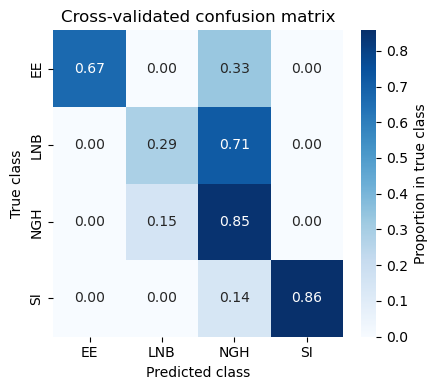

In [19]:
# ============================================================
# 📊  Evaluation cell – metrics + per-class accuracy heat-map
# ============================================================

from sklearn.model_selection import cross_val_predict
from sklearn.metrics         import (
    accuracy_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ------------------------------------------------------------------
# 1) Cross-validated predictions with the tuned pipeline
# ------------------------------------------------------------------
best_model = grid.best_estimator_          # from the previous GridSearch
y_cv_pred  = cross_val_predict(best_model, X_scaled, y_num, cv=cv)

# ------------------------------------------------------------------
# 2) Global metrics
# ------------------------------------------------------------------
print("Cross-validated overall metrics")
print(f"  Accuracy        : {accuracy_score(y_num, y_cv_pred):.3f}")
print(f"  Balanced recall : {recall_score(y_num, y_cv_pred, average='macro'):.3f}")
print(f"  Macro-F1        : {f1_score(y_num, y_cv_pred, average='macro'):.3f}\n")

print("Per-class precision / recall / F1")
print(classification_report(
    y_num, y_cv_pred,
    target_names=['EE', 'LNB', 'NGH', 'SI'],
    digits=3
))

# ------------------------------------------------------------------
# 3) Heat-map of per-class recall (row-normalised confusion matrix)
# ------------------------------------------------------------------
cm       = confusion_matrix(y_num, y_cv_pred)
cm_norm  = cm / cm.sum(axis=1, keepdims=True)      # rows sum to 1
labels   = ['EE', 'LNB', 'NGH', 'SI']
df_cm    = pd.DataFrame(cm_norm, index=labels, columns=labels)

plt.figure(figsize=(4.5, 4))
sns.heatmap(df_cm,
            annot=True, fmt=".2f",
            cmap="Blues",
            cbar_kws={'label': 'Proportion in true class'})
plt.title("Cross-validated confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Using 5-fold stratified CV.

=== Cross-validated overall metrics (PCA=25) ===
Accuracy        : 0.636
Balanced Recall : 0.631
Macro-F1        : 0.656

Per-class precision / recall / F1
              precision    recall  f1-score   support

          EE      1.000     0.833     0.909         6
         LNB      0.429     0.429     0.429         7
         NGH      0.562     0.692     0.621        13
          SI      0.800     0.571     0.667         7

    accuracy                          0.636        33
   macro avg      0.698     0.631     0.656        33
weighted avg      0.664     0.636     0.642        33



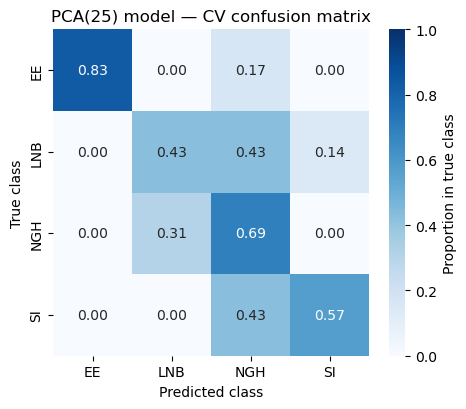

[CV] END ...................clf__C=0.01, pca__n_components=8; total time=   0.0s
[CV] END ..................clf__C=0.01, pca__n_components=12; total time=   0.0s
[CV] END ..................clf__C=0.01, pca__n_components=15; total time=   0.0s
[CV] END .................clf__C=0.01, pca__n_components=0.9; total time=   0.0s
[CV] END ...clf__C=0.046415888336127774, pca__n_components=5; total time=   0.0s
[CV] END ..clf__C=0.046415888336127774, pca__n_components=10; total time=   0.0s
[CV] END .clf__C=0.046415888336127774, pca__n_components=0.9; total time=   0.0s
[CV] END ....clf__C=0.21544346900318834, pca__n_components=8; total time=   0.0s
[CV] END ...clf__C=0.21544346900318834, pca__n_components=12; total time=   0.0s
[CV] END ...clf__C=0.21544346900318834, pca__n_components=12; total time=   0.0s
[CV] END ....................clf__C=1.0, pca__n_components=8; total time=   0.0s
[CV] END ....................clf__C=1.0, pca__n_components=8; total time=   0.0s
[CV] END ......clf__C=4.6415

In [22]:
# ============================================================
#  Evaluate: PCA(25) ➜ Logistic Regression  (CV + heatmap)
# ============================================================

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# ---------- 0) Set PCs and a robust CV splitter ----------
# Cap PCs by data limits to avoid PCA errors if n_samples < 25
n_comp = min(25, X_scaled.shape[0], X_scaled.shape[1])
if n_comp < 25:
    print(f"Note: using {n_comp} PCs (capped by n_samples/features).")

# Pick CV folds so every class has at least one sample per fold
class_counts = np.bincount(y_num)
min_count = class_counts.min()
n_splits = max(2, min(5, int(min_count)))
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
print(f"Using {n_splits}-fold stratified CV.")

# ---------- 1) Build the pipeline ----------
# Reuse tuned C if available; else default to 1.0
try:
    best_C = grid.best_params_['clf__C']
except Exception:
    best_C = 1.0

pipe25 = Pipeline([
    ('pca', PCA(n_components=n_comp, random_state=0)),
    ('clf', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        penalty='l2',
        C=best_C,
        max_iter=10_000))
])

# ---------- 2) Cross-validated predictions ----------
y_cv_pred = cross_val_predict(pipe25, X_scaled, y_num, cv=cv)

# ---------- 3) Derive class names dynamically ----------
# If you still have `le` (LabelEncoder), prefer that; else infer from y strings
try:
    class_ids = np.sort(np.unique(y_num))
    class_names = [le.classes_[i] for i in class_ids]
except Exception:
    try:
        y_series = pd.Series(y)  # original string labels aligned with X_scaled
        class_names = [y_series[y_num == i].mode().iat[0] for i in np.sort(np.unique(y_num))]
    except Exception:
        # Fallback: sorted unique integers as strings
        class_names = [str(i) for i in np.sort(np.unique(y_num))]

# ---------- 4) Global metrics ----------
print("\n=== Cross-validated overall metrics (PCA=25) ===")
print(f"Accuracy        : {accuracy_score(y_num, y_cv_pred):.3f}")
print(f"Balanced Recall : {recall_score(y_num, y_cv_pred, average='macro'):.3f}")
print(f"Macro-F1        : {f1_score(y_num, y_cv_pred, average='macro'):.3f}\n")

print("Per-class precision / recall / F1")
print(classification_report(y_num, y_cv_pred, target_names=class_names, digits=3))

# ---------- 5) Heat-map of per-class recall (row-normalised CM) ----------
cm = confusion_matrix(y_num, y_cv_pred, labels=np.sort(np.unique(y_num)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

df_cm = pd.DataFrame(cm_norm, index=class_names, columns=class_names)
plt.figure(figsize=(4.8, 4.2))
sns.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues",
            vmin=0, vmax=1, cbar_kws={'label': 'Proportion in true class'})
plt.title("PCA(25) model — CV confusion matrix")
plt.ylabel("True class"); plt.xlabel("Predicted class")
plt.tight_layout(); plt.show()


In [20]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Get PC scores
Z = pca_model.transform(X_scaled)       # shape (33, 12)
pc_df = pd.DataFrame(Z[:, :3], columns=['PC1', 'PC2', 'PC3'])
pc_df['class'] = y                     # original string labels

for pc in ['PC1', 'PC2', 'PC3']:
    groups = [grp[pc].values for name, grp in pc_df.groupby('class')]
    F, p = stats.f_oneway(*groups)
    print(f"{pc}:  F = {F:.2f},  p = {p:.4f}")
    
    if p < 0.05:
        posthoc = pairwise_tukeyhsd(endog=pc_df[pc], groups=pc_df['class'])
        print(posthoc.summary())


NameError: name 'pca_model' is not defined

In [21]:
# ===============================================
#  Prepare the 12-D PC matrix and a tidy DataFrame
# ===============================================
import numpy as np, pandas as pd
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multitest     import multipletests
from scipy import stats
from skbio.stats.distance import DistanceMatrix, permanova
from scipy.spatial.distance import pdist, squareform

# 1) 12-D scores
Z12 = best_model.named_steps['pca'].transform(X_scaled)[:, :12]   # (33 × 12)

df = pd.DataFrame(Z12, columns=[f'PC{i+1}' for i in range(12)])
df['group'] = y                         # original string labels ('EE', 'LNB', ...)

# ===============================================
#  STEP 1 — MANOVA
# ===============================================
formula = ' + '.join(df.columns[:-1]) + ' ~ group'        # PC1 + PC2 + ... ~ group
mv = MANOVA.from_formula(formula, data=df)
print("\n=== MANOVA (Wilks’ λ, Pillai’s trace) ===")
print(mv.mv_test())           # shows Wilks, Pillai, Hotelling, Roy

# ===============================================
#  STEP 2 — PC-wise ANOVAs  +  BH FDR
# ===============================================
p_vals = []
for pc in df.columns[:-1]:
    groups = [df.loc[df['group'] == g, pc] for g in df['group'].unique()]
    F, p = stats.f_oneway(*groups)
    p_vals.append(p)

# FDR-correct
rej, p_adj, _, _ = multipletests(p_vals, method='fdr_bh')
pc_results = pd.DataFrame({
    'PC'        : df.columns[:-1],
    'raw_p'     : p_vals,
    'FDR_p'     : p_adj,
    'signif'    : rej
}).sort_values('FDR_p')
print("\n=== PC-wise ANOVA (BH-FDR corrected) ===")
print(pc_results.to_string(index=False))

# ===============================================
#  OPTIONAL — PERMANOVA  (non-parametric backup)
# ===============================================
# Euclidean distances in 12-D space
D = squareform(pdist(Z12, metric='euclidean'))
dm = DistanceMatrix(D, ids=list(range(len(y))))
perma_res = permanova(dm, y, permutations=999)
print("\n=== PERMANOVA on 12-PC Euclidean distances ===")
print(perma_res)

ModuleNotFoundError: No module named 'skbio'

# Embedding Visualization

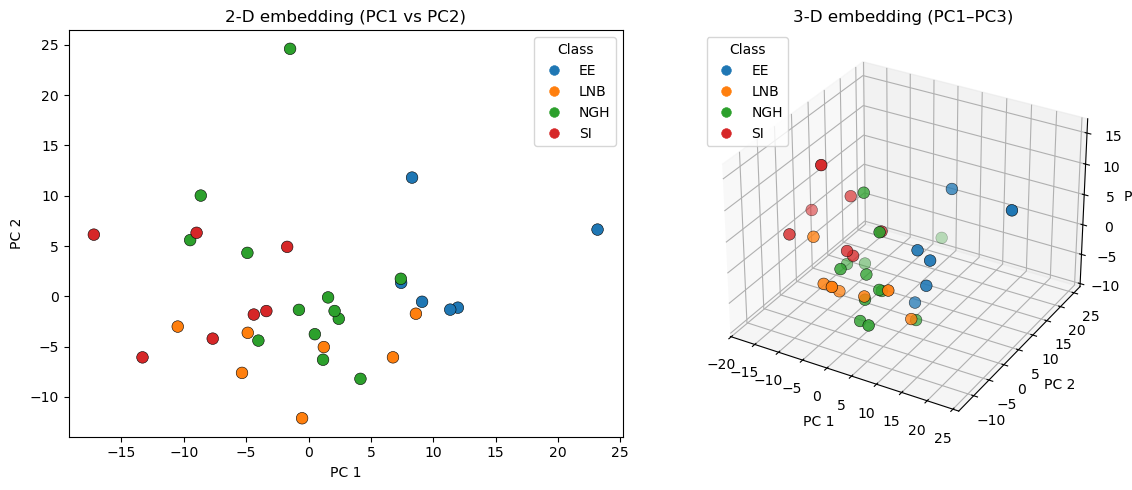

In [22]:
# ============================================================
#  Latent embeddings – PCA space
#  • Left  : PC-1 vs PC-2   (2-D)
#  • Right : PC-1 vs PC-2 vs PC-3  (3-D)
# ============================================================

# %matplotlib widget   # ← uncomment for interactive rotation in Jupyter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ------------------------------------------------------------------
# 1) Get the latent coordinates from the tuned pipeline
# ------------------------------------------------------------------
pca_model = grid.best_estimator_.named_steps['pca']
Z = pca_model.transform(X_scaled)    # shape (33, 12)
Z2, Z3 = Z[:, :2], Z[:, :3]          # first 2 & first 3 PCs

# ------------------------------------------------------------------
# 2) Categorical tab10 palette (blue, orange, green, red)
# ------------------------------------------------------------------
base_cmap = mpl.cm.get_cmap('tab10')
cat_cmap  = mpl.colors.ListedColormap([base_cmap(i) for i in range(4)])
norm      = mpl.colors.BoundaryNorm(np.arange(-0.5, 4.5), cat_cmap.N)

label_names = ['EE', 'LNB', 'NGH', 'SI']   # order must match label encoding
handles = [mpl.lines.Line2D([], [], marker='o', linestyle='',
                            markersize=7, markeredgewidth=0.4,
                            color=cat_cmap(i), label=lab)
           for i, lab in enumerate(label_names)]

# ------------------------------------------------------------------
# 3) Build the figure – 2-D (left) + 3-D (right)
# ------------------------------------------------------------------
fig = plt.figure(figsize=(12, 5))

# --- 2-D plot ------------------------------------------------------
ax2 = fig.add_subplot(1, 2, 1)
ax2.scatter(Z2[:, 0], Z2[:, 1],
            c=y_num, cmap=cat_cmap, norm=norm,
            s=70, edgecolor='k', linewidth=0.4)
ax2.set_xlabel('PC 1'); ax2.set_ylabel('PC 2')
ax2.set_title('2-D embedding (PC1 vs PC2)')
ax2.legend(handles=handles, title='Class', loc='best')

# --- 3-D plot ------------------------------------------------------
ax3 = fig.add_subplot(1, 2, 2, projection='3d')
ax3.scatter(Z3[:, 0], Z3[:, 1], Z3[:, 2],
            c=y_num, cmap=cat_cmap, norm=norm,
            s=70, edgecolor='k', linewidth=0.4)
ax3.set_xlabel('PC 1'); ax3.set_ylabel('PC 2'); ax3.set_zlabel('PC 3')
ax3.set_title('3-D embedding (PC1–PC3)')

# Use the same legend handles in 3-D (upper-left corner of the panel)
ax3.legend(handles=handles, title='Class', loc='upper left')

plt.tight_layout()
plt.show()


# Saving Objects

In [23]:
# ============================================================
#  Save 12-PC embedding + labels + UUIDs
# ============================================================

import pandas as pd
import numpy as np
import joblib
import os

# ── 1) 12-PC coordinates from the tuned pipeline ─────────────
Z12 = best_model.named_steps['pca'].transform(X_scaled)[:, :25]    # shape (n_samples, 12)

# ── 2) Build a DataFrame --------------------------------------
embed_df = pd.DataFrame(Z12, columns=[f'PC{i+1}' for i in range(25)])

embed_df['category'] = y            # string labels: 'EE', 'LNB', 'NGH', 'SI'
embed_df['uuid']     = uuid_vec        # <- make sure `uuids` is a 1-D array/list aligned with X

# Optional: move label columns to the front
cols = ['uuid', 'category'] + [c for c in embed_df.columns if c.startswith('PC')]
embed_df = embed_df[cols]

# ── 3) Choose an output path ----------------------------------
out_dir = "/om2/user/mabdel03/files/BTI/Moseq_3-27-2025_Run/Offsprings/data/analysis_output/constructed_fingerprints/Females"
os.makedirs(out_dir, exist_ok=True)

csv_path   = os.path.join(out_dir, "offspring_PCA25_embedding.csv.gz")
pkl_path   = os.path.join(out_dir, "offspring_PCA25_embedding.pkl")

# ── 4) Write to disk ------------------------------------------
embed_df.to_csv(csv_path, index=False, compression="gzip")
embed_df.to_pickle(pkl_path)

print(f"✅ Saved 12-PC embedding\n  • {csv_path}\n  • {pkl_path}")

# ── 5) (Optional) save the fitted model itself ----------------
joblib.dump(best_model, os.path.join(out_dir, "pca12_logreg.joblib"))


✅ Saved 12-PC embedding
  • ../../data/analysis_output/constructed_fingerprints/Females/offspring_PCA25_embedding.csv.gz
  • ../../data/analysis_output/constructed_fingerprints/Females/offspring_PCA25_embedding.pkl


['../../data/analysis_output/constructed_fingerprints/Females/pca12_logreg.joblib']

In [24]:
import pandas as pd
embed_df = pd.read_pickle("../../data/analysis_output/constructed_fingerprints/Females/offspring_PCA25_embedding.pkl")
# or: pd.read_csv("...csv.gz")


In [25]:
embed_df

,uuid,category,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,add943f9-2caf-47ff-80d1-b825d3419b37,NGH,-1.481707,24.608028,-7.444133,-11.307820,1.527056,-4.153057,7.359201,-0.383851,...,-1.645692,-2.731629,-1.335388,-0.482134,-0.030630,-1.714362,2.355093,-0.883881,-0.103883,-0.977220
1,6271b7ca-21da-475e-aa9a-021f3fbfe725,NGH,1.161096,-6.299882,-6.602607,5.839993,5.535388,-0.690111,0.295096,-1.636198,...,-5.702750,0.703756,-0.172945,2.881554,2.121607,0.410574,1.502224,0.272877,4.663840,1.608720
2,d5fe97bf-c8c6-4400-bd91-1a355888d818,SI,-3.384283,-1.459206,0.773665,1.158345,4.387953,3.026842,0.819021,-0.984005,...,7.434156,2.586884,1.670080,-1.215563,0.020143,-0.200605,2.224844,-0.746591,0.503098,-1.329001
3,f32cc80e-36a8-4cf6-823e-478f8eb4af38,NGH,2.422226,-2.227157,-3.075280,-0.414893,2.584938,-2.128171,0.813936,1.743914,...,-1.398054,0.667373,-4.405123,0.008528,3.984557,-3.072950,-3.704110,-1.519545,3.643564,-2.591354
4,3ac8d60e-8a2c-4244-9761-658ef5682856,LNB,-0.519020,-12.114787,1.317857,-4.017846,-3.581938,-0.405399,1.543203,0.491111,...,-0.690114,-2.898086,-0.316968,0.722288,-0.885345,-2.015325,1.811440,-0.525129,0.207496,-0.292860
5,2a84130d-6477-4fcc-a644-eb0527024917,NGH,2.086985,-1.455639,5.885801,2.743016,-2.743319,0.506260,-2.984237,6.758544,...,1.231825,-1.035384,-2.275319,2.286530,0.409325,-4.236482,-0.516619,-4.801927,-0.078378,2.174755
6,9af80187-1f8b-4a78-bdf6-9cdcaea7c7a8,EE,7.423226,1.347147,-5.626540,3.149399,-0.528119,0.709819,-3.528038,1.813236,...,-3.223817,-0.052459,1.749549,-3.414038,-2.853426,3.965361,-2.831411,0.609777,1.692262,1.688363
7,774ba130-08f1-45ee-9c61-636e6de87827,SI,-13.315558,-6.063129,3.998677,4.385434,5.828232,-0.810497,3.810909,-1.307332,...,-2.198445,3.617548,-1.531329,-0.453886,0.532233,-3.945409,0.148655,1.170640,-3.714841,-2.219023
8,3f11e55d-f6ca-4f1e-889b-194e312985a1,LNB,-5.336033,-7.604247,-1.471839,-2.585326,-2.429485,-1.848390,-1.461386,-0.093698,...,-0.301061,1.533632,-0.696546,-0.835785,-0.835849,0.573735,1.199711,-1.053951,-2.261023,-1.460987
9,5083529c-320b-4bea-9ceb-d119b2594f13,NGH,-4.023883,-4.397324,-0.216554,-2.016008,-4.304283,1.271473,7.915787,-3.023034,...,6.002137,0.993517,-0.176488,-0.073510,2.526731,0.709873,-0.754943,4.016852,2.676931,1.084237


Embedding dimensionality: 25 PCs

Adjusted Rand Index : 0.202
V-measure           : 0.388

Cluster vs. true category counts:
Cluster  0  1  2  3
True               
EE       0  1  0  5
LNB      5  0  2  0
NGH      7  0  4  2
SI       1  0  6  0


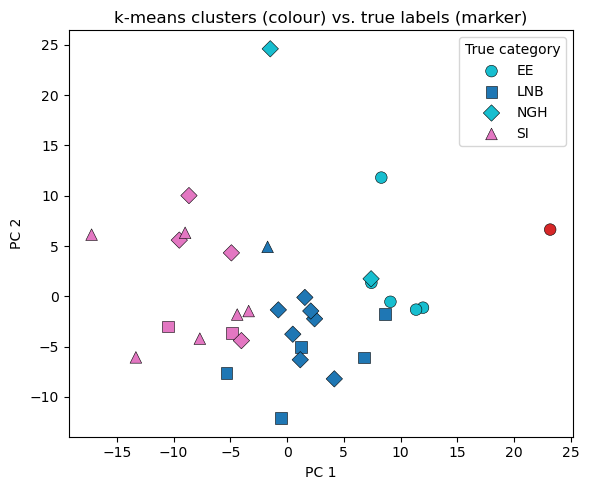

In [26]:
# ============================================================
#  Does k-means (k=4) recover the true categories in PC space?
# ============================================================

from sklearn.cluster         import KMeans
from sklearn.metrics         import adjusted_rand_score, v_measure_score
from sklearn.preprocessing   import LabelEncoder
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import seaborn as sns

# ------------------------------------------------------------------
# 1) Grab the latent coordinates from the tuned pipeline
#    (works for either 12-PC or 95-% models)
# ------------------------------------------------------------------
pca      = best_model.named_steps['pca']
Z        = pca.transform(X_scaled)                # (n_samples, n_PCs)
pc_count = pca.n_components_
print(f"Embedding dimensionality: {pc_count} PCs")

# ------------------------------------------------------------------
# 2) k-means with *fixed* k = 4
# ------------------------------------------------------------------
kmeans   = KMeans(n_clusters=4, random_state=0, n_init=20)
clusters = kmeans.fit_predict(Z)

# ------------------------------------------------------------------
# 3) Agreement metrics
# ------------------------------------------------------------------
ari       = adjusted_rand_score(y_num, clusters)
v_measure = v_measure_score(y_num, clusters)
print(f"\nAdjusted Rand Index : {ari:.3f}")
print(f"V-measure           : {v_measure:.3f}")

# ------------------------------------------------------------------
# 4) Confusion table: cluster ↔ true category
# ------------------------------------------------------------------
# Map category integers back to strings if needed
encoder = LabelEncoder().fit(y) if isinstance(y[0], str) else None
true_labels = y if isinstance(y[0], str) else encoder.inverse_transform(y_num)

conf = pd.crosstab(true_labels, clusters,
                   rownames=['True'], colnames=['Cluster'], dropna=False)
print("\nCluster vs. true category counts:")
print(conf)

# ------------------------------------------------------------------
# 5) 2-D scatter (PC1 vs PC2), coloured by cluster, shape by true label
# ------------------------------------------------------------------
Z2 = Z[:, :2]                                       # PC1–PC2
cmap = mpl.cm.get_cmap('tab10', 4)                 # 4 distinct colours
markers = {'EE':'o', 'LNB':'s', 'NGH':'D', 'SI':'^'}

plt.figure(figsize=(6,5))
for lab in np.unique(true_labels):
    idx = (true_labels == lab)
    plt.scatter(Z2[idx,0], Z2[idx,1],
                c=clusters[idx], cmap=cmap, norm=mpl.colors.BoundaryNorm(
                    np.arange(-0.5,4.5), cmap.N),
                marker=markers.get(lab, 'o'),
                edgecolor='k', linewidth=0.4, s=70, label=lab)
plt.legend(title='True category'); plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.title('k-means clusters (colour) vs. true labels (marker)')
plt.tight_layout(); plt.show()
